In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np

ds = tfds.load('fashion_mnist', split='train')

In [ ]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

each row in our dataset has an image and a label.

In [ ]:
iter = ds.as_numpy_iterator()

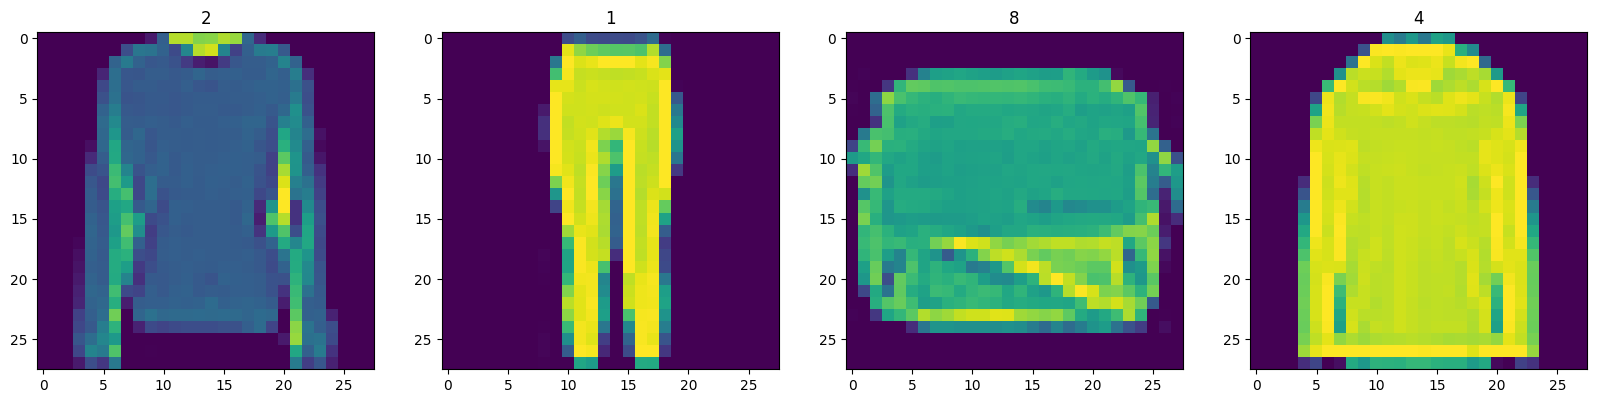

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample = iter.next()
    ax[idx].imshow(np.squeeze(sample['image'])) # squeeze is used to change the shaped from (28, 28, 1) -> (28, 28)
    ax[idx].title.set_text(sample['label'])

In [ ]:
labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
def preprocess_row(row):
  row['image'] = row['image']/255
  row['label'] = tf.one_hot(row['label'], 10)
  return row

In [ ]:
ds = ds.map(preprocess_row)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128) #batch size will be 128
ds = ds.prefetch(64) #prefetch next 64 rows

In [ ]:
ds.as_numpy_iterator().next()['image'].shape

(128, 28, 28, 1)

There are 128 images of 28x28 dimensions and 1 channel

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Input, Embedding, Concatenate

In [ ]:
def build_generator():
    noise_input = Input(shape=(128,))
    label_input = Input(shape=(10,))

    label_embedding = Dense(7 * 7)(label_input)
    label_embedding = Reshape((7, 7, 1))(label_embedding)

    # Upscaling label channels to have an equal influence in training
    label_embedding = Conv2D(128, kernel_size=1, padding='same')(label_embedding)  # Now shape (7, 7, 128)

    # Process noise and reshape
    noise_dense = Dense(7 * 7 * 128)(noise_input)
    noise_reshape = Reshape((7, 7, 128))(noise_dense)

    # Concatenate along the channels
    combined = Concatenate()([noise_reshape, label_embedding])  # Resulting shape (7, 7, 256)

    # Generator layers
    x = UpSampling2D()(combined)
    x = Conv2D(128, 5, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    x = UpSampling2D()(x)
    x = Conv2D(128, 5, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, 4, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, 4, padding='same')(x)
    x = LeakyReLU(0.2)(x)

    # Final Conv2D layer to output a single channel (grayscale image)
    output = Conv2D(1, 4, padding='same', activation='sigmoid')(x)

    return Model([noise_input, label_input], output)


In [ ]:
generator = build_generator()
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 49)             │            539 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6272)           │        809,088 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 7, 7, 1)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 7, 7, 128)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 7, 7, 128)      │            256 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 7, 7, 256)      │              0 │ reshape_1[0][0],       │
│                           │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 14, 14, 256)    │              0 │ concatenate[0][0]      │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 128)    │        819,328 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 14, 14, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 28, 28, 128)    │              0 │ leaky_re_lu[0][0]      │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │        409,728 │ up_sampling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 28, 28, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 128)    │        262,272 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 28, 28, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 128)    │        262,272 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyR

 Total params: 2,565,532 (9.79 MB)

 Trainable params: 2,565,532 (9.79 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


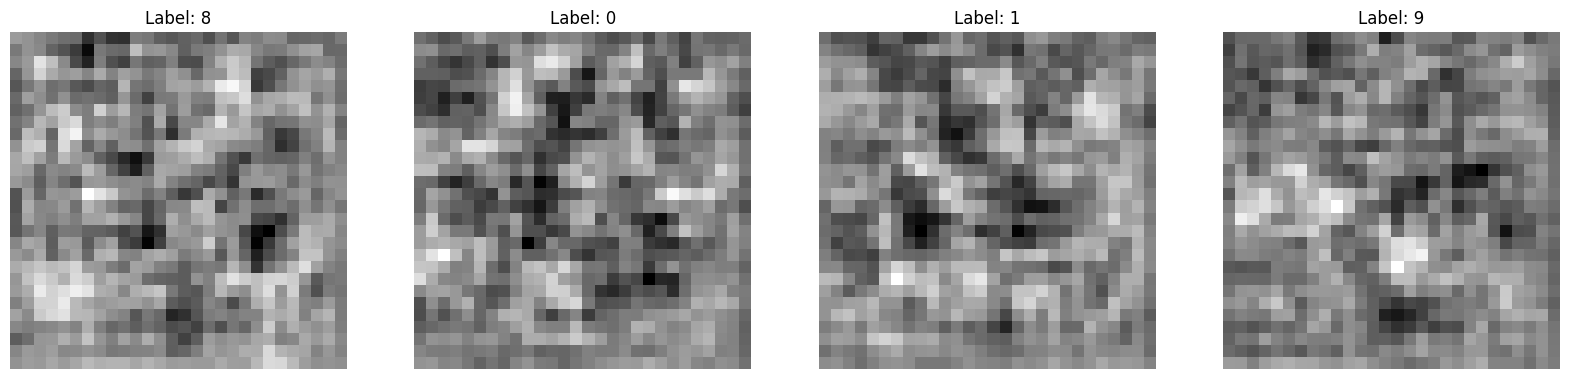

In [ ]:
num_images = 4
noise_dim = 128

# Random noise and labels
random_noise = np.random.randn(num_images, noise_dim)
random_labels = np.random.randint(0, 10, num_images)

# One-hot encode the labels
labels_ohe = tf.one_hot(random_labels, 10)

generated_images = generator.predict([random_noise, labels_ohe])

fig, ax = plt.subplots(ncols=num_images, figsize=(20, 20))
for idx, img in enumerate(generated_images):
    ax[idx].imshow(np.squeeze(img), cmap='gray')
    label_index = tf.argmax(labels_ohe[idx]).numpy()  # Convert to numpy and get index of max value
    ax[idx].title.set_text(f"Label: {label_index}")
    ax[idx].axis('off')  # Hide axes

plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Conv2D, LeakyReLU, Dropout, Flatten
from tensorflow.keras.models import Model

def build_discriminator():
    # Image input
    image_input = Input(shape=(28, 28, 1))

    # Label input and embedding
    label_input = Input(shape=(10,))
    label_embedding = Dense(28 * 28)(label_input)  # Expand to match image dimensions
    label_embedding = Reshape((28, 28, 1))(label_embedding)  # Shape to (28, 28, 1)

    # Concatenate image and label embedding along the channel dimension
    combined_input = Concatenate()([image_input, label_embedding])  # Resulting shape: (28, 28, 2)

    # Convolutional layers for the discriminator
    x = Conv2D(32, kernel_size=5, strides=2, padding="same")(combined_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)

    x = Conv2D(64, kernel_size=5, strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)

    x = Conv2D(128, kernel_size=5, strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)

    x = Conv2D(256, kernel_size=5, strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)

    # Flatten and output layer
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model([image_input, label_input], output)

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 784)            │          8,624 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 28, 28, 1)      │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 28, 28, 2)      │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 14, 14, 32)     │          1,632 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 14, 14, 32)     │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 14, 14, 32)     │              0 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 7, 7, 64)       │         51,264 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 7, 7, 64)       │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 7, 7, 64)       │              0 │ leaky_re_lu_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 4, 4, 128)      │        204,928 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 4, 4, 128)      │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 4, 4, 128)      │              0 │ leaky_re_lu_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 2, 2, 256)      │        819,456 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 2, 2, 256)      │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 2, 2, 256)      │              0 │ leaky_re_lu_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1024)           │              0 │ dropout_3[0][0]        │
├──────────────────────

 Total params: 1,086,929 (4.15 MB)

 Trainable params: 1,086,929 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator.predict([generated_images, labels_ohe])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


array([[0.49619517],
       [0.4968765 ],
       [0.49723712],
       [0.49719772]], dtype=float32)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001) # we want discriminator to learn slower than the generator so that we doesn't classify every image as 1 initially
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
class ConditionalFashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Assume batch_size is fixed to 128
        batch_size = 128

        # Extract the real images and labels from the batch dictionary
        real_images = batch['image']
        labels = batch['label']

        # Generate fake images
        random_latent_vectors = tf.random.normal((batch_size, 128))  # Noise vector
        generated_images = self.generator([random_latent_vectors, labels], training=True)

        # Combine real and fake images
        combined_images = tf.concat([real_images, generated_images], axis=0)
        combined_labels = tf.concat([labels, labels], axis=0)

        # Create labels for real and fake images
        real_fake_labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Train discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels], training=True)
            d_loss = self.d_loss(real_fake_labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Train generator
        misleading_labels = tf.zeros((batch_size, 1))  # Labels are all zeros for the generator
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, labels], training=True)
            predictions = self.discriminator([generated_images, labels], training=False)
            g_loss = self.g_loss(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

In this case, because we're using ds.batch(128), the batch passed to train_step will not be an array of dictionaries. Instead, it will be a dictionary itself containing the batched images and labels. Each of the dictionary's keys (e.g., 'image', 'label') will now hold a tensor of shape (batch_size, height, width, channels) or (batch_size, num_classes) depending on the type of data.

**Data format after batching**

Your dataset is a tf.data.Dataset object that, after batching, will yield a single dictionary per batch. This dictionary contains:

- 'image': a tensor of shape (batch_size, 28, 28, 1) representing a batch of images
- 'label': a tensor of shape (batch_size, 10) representing the one-hot encoded labels for each image in the batch

This is still a batch of data, but it's not an array of dictionaries; it's a single dictionary containing batched tensors.

In [ ]:
fashgan = ConditionalFashionGAN(generator, discriminator)

fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
hist = fashgan.fit(ds, epochs=5)

Epoch 1/5
  3/469 ━━━━━━━━━━━━━━━━━━━━ 3:08:00 24s/step - d_loss: 0.6942 - g_loss: 0.6905

KeyboardInterrupt: 

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        # Generate random latent vectors and random labels
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))  # Latent vectors (normal distribution)
        random_labels = tf.random.uniform((self.num_img,), minval=0, maxval=10, dtype=tf.int32)  # Random labels (integers from 0 to 9)
        labels_ohe = tf.one_hot(random_labels, 10)  # One-hot encode labels (shape: [num_img, 10])

        # Generate images using the generator
        generated_images = self.model.generator([random_latent_vectors, labels_ohe], training=False)

        # Scale the generated images to the range [0, 255]
        generated_images = (generated_images * 255).numpy().astype(np.uint8)  # Convert to range [0, 255]

        # Ensure the 'images' folder exists
        os.makedirs('images', exist_ok=True)

        # Save the generated images
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
num_images = 12
noise_dim = 128

# Random noise and labels
random_noise = np.random.randn(num_images, noise_dim)
random_labels = np.random.randint(0, 10, num_images)

# One-hot encode the labels
labels_ohe = tf.one_hot(random_labels, 10)

generated_images = generator.predict([random_noise, labels_ohe])

fig, ax = plt.subplots(ncols=num_images, figsize=(20, 20))
for idx, img in enumerate(generated_images):
    ax[idx].imshow(np.squeeze(img), cmap='gray')
    label_index = tf.argmax(labels_ohe[idx]).numpy()
    ax[idx].title.set_text(f"Label: {label_index}")
    ax[idx].axis('off')

plt.show()